# DMRG tutorial: Getting started

The aim of this tutorial is to show how the **Density Matrix Renormalization Group (DMRG)** algorithm can be used to simulate adiabatic Pulser sequences.
DMRG is a powerful variational method for finding the ground state of 1D and 2D quantum many-body systems. In practice, it can be used to
- Simulate adiabatic Pulser sequences.
- find the ground state of a specific Hamiltonian

> In this context, DMRG is used to replicate time evolution in the limit of infinite total duration — i.e., for very slow, adiabatic pulse sequences. For a detailed description about the adiabatic theorem and its applications, please refer to [[1]](https://en.wikipedia.org/wiki/Adiabatic_theorem), [[2]](https://arxiv.org/pdf/2406.12392), and [[3]](https://arxiv.org/pdf/1611.04471).

This is because in this regime, the evolved state remains (to a good approximation) in the ground state of the instantaneous Hamiltonian, so finding those ground states with DMRG at different times reproduces the adiabatic outcome. 

For more information about the DMRG solver, please refer to the [DMRG documentation](../advanced/algorithms.md#density-matrix-renormalization-group-dmrg)

Let us start by importing the main components required to run a Pulser simulation with the `DMRG` solver:
- **MPS**: a class for constructing a matrix product state MPS
- **MPSConfig**: a configuration class for setting up the `emu-mps` MPSBackend
- **MPSBackend**: the backend class that runs pulse sequences using MPS
- **Bitstrings, Fidelity, Occupation**: observables that can be measured at specified *evaluation times* during the simulation
- **Solver**: a class for selecting the algorithm to be used in the simulation. Two solvers are currently supported:
    - `TDVP` (default): can be used to simulate any Pulser sequence
    - `DMRG`: can be used to efficiently simulate adiabatic Pulser sequences
- **pulser**: The Pulser library, used to construct the experiment (register, lasers, and pulse sequences).  


In [18]:
# standard library
from typing import Any
import numpy as np
import math

# visualization
import matplotlib.pyplot as plt

# Pulser
import pulser
from pulser.devices import AnalogDevice

# emu-mps 
from emu_mps import (
    MPS,
    MPSConfig,
    MPSBackend,
    BitStrings,
    Fidelity,
    Occupation,
)
from emu_mps.solver import Solver


## Running a simulation using `emu-mps`

`emu-mps` is a Pulser backend designed to **emulate** the dynamics of programmable arrays of neutral atoms.
The simulation is executed via the `run` method of the **MPSBackend**, which takes two arguments:
- a valid Pulser **sequence**,
- an **MPSConfig** object (configuration file)

In this tutorial, we demonstrate how to trigger the `DMRG` algorithm to simulate adiabatically an antiferromagnetic (AFM) sequence.  
The workflow proceeds as follows:  
1. **Create the atomic register** using Pulser
2. **Design a pulse sequence** (`sequence`) that drives the system into the AFM state for the given register
3. **Configure the simulation** by creating an MPSConfig object (`mpsconfig_obj`), and specifying observables (e.g, bitstrings, fidelity, occupation) and other parameters such as the time step
4. **Instantiate the MPSBackend** (`mps_backend`)
5. **Run the simulation** using `mps_backend.run(sequence, mpsconfig_obj)`
5. **Extract the results**

### Register and Sequence creation

To make this tutorial focused on the backend functionalities, we use two auxiliary functions to quickly set up the Pulser object. 

- **square_perimeter_points**: computes the coordinates of the atoms located on the perimeter of a square.
    - the atoms are labeled starting from the bottom-left corner and moving counter-clockwise.  
    - note that the ordering of atom positions determines the ordering of the measured bitstrings.  

- **afm_sequence_from_register**: creates a pulse sequence that prepares the AFM state for the given register. 
    - The sequence consists of three phases: **rise**, **sweep**, and **fall**, with the sweep duration chosen proportional to the rise and fall times.  


In [19]:
def afm_sequence_from_register(
    reg: pulser.Register,
    Omega_max: float,
    delta_0: float,
    delta_f: float,
    t_rise: int,
    t_fall: int,
    factor_sweep: int,
    device: Any = pulser.devices.MockDevice,
) -> pulser.Sequence:
    """Sequence that creates AntiFerromagnetic State (AFM) for 1d chain of atoms using pulser.
    This function constructs a sequence of pulses to transition a system of qubits
    distributed in a 1d chain (represented by `reg`) into an AFM state using a specified device.
    The sequence consists of three phases: a rise, a sweep, and a fall.
    ."""

    t_sweep = (delta_f - delta_0) / (2 * np.pi * 10) * 1000 * factor_sweep
    rise = pulser.Pulse.ConstantDetuning(
        pulser.waveforms.RampWaveform(t_rise, 0.0, Omega_max), delta_0, 0.0
    )
    sweep = pulser.Pulse.ConstantAmplitude(
        Omega_max, pulser.waveforms.RampWaveform(int(t_sweep), delta_0, delta_f), 0.0
    )
    fall = pulser.Pulse.ConstantDetuning(
        pulser.waveforms.RampWaveform(t_fall, Omega_max, 0.0), delta_f, 0.0
    )

    seq = pulser.Sequence(reg, device)
    seq.declare_channel("ising_global", "rydberg_global")
    seq.add(rise, "ising_global")
    seq.add(sweep, "ising_global")
    seq.add(fall, "ising_global")

    return seq


def square_perimeter_points(L: int) -> np.ndarray:
    """
    Calculate the coordinates of the points located on the perimeter of a square of size L.
    The square is centered at the origin (0, 0) with sides parallel to the axes.
    The points are ordered starting from the bottom-left corner and moving
    counter-clockwise around the square. The order is important when measuare the bitstrings

    Args:
        L (int): The length of the side of the square. L should be a positive integer.

    Returns:
        np.ndarray: An array of shape (4*L-4, 2) containing the coordinates of the perimeter points.

    Example:
        >>> square_perimeter_points(3)
        array([[-1, -1],
               [-1,  0],
               [-1,  1],
               [ 0,  1],
               [ 1,  1],
               [ 1,  0],
               [ 1, -1],
               [ 0, -1]])
    """
    pairOrodd = L % 2
    toGrid = int(math.floor(L / 2))
    if pairOrodd == 0:
        axis = list(range(-toGrid, toGrid, 1))
    else:
        axis = list(range(-toGrid, toGrid + 1, 1))
    coord = []
    for i in axis:  # from left, first column of the perimeter
        coord.append([axis[0], i])

    for i in axis[1:-1]:
        coord.append([i, axis[-1]])

    for i in reversed(axis):
        coord.append([axis[-1], i])

    for i in reversed(axis[1:-1]):
        coord.append([i, axis[0]])

    return np.array(coord)

We begin by defining the main physical parameters needed to prepare the system. For the reader's conveninence we recall their meaning:
- **Omega_max**: peak laser amplitude used in the pulse sequence
- **delta_0**: initial detuning of the pulse
- **delta_f**: final detuning of the pulse
- **t_rise**:duration of the rise phase
- **t_fall**: duraction of the fall phase
- **sweep_factor**: scale factor expressing the duration of the sweep phase in terms of `delta_f - delta_0`

Note that the interatomic distance is chosen to scale with `Omega_max`, so that the interaction strength in the system is relative to the pulse parameters.

In [20]:
Omega_max = 2 * 2 * np.pi
delta_0 = -6 * Omega_max / 2
delta_f = 1 * Omega_max / 2
t_rise = 500
t_fall = 1500
sweep_factor = 2

square_length = 3
R_interatomic = AnalogDevice.rydberg_blockade_radius(Omega_max / 2)

As discussed above, we begin with the first step:

**Create the atomic register using Pulser.**

In this example, the register consists of a square array of 8 atoms.

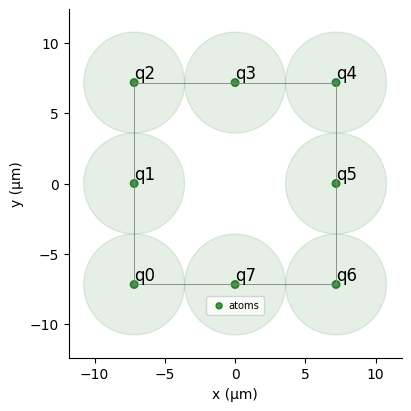

In [21]:
coords = R_interatomic * square_perimeter_points(square_length)
reg = pulser.Register.from_coordinates(coords,prefix='q')
reg.draw(blockade_radius=R_interatomic, draw_graph=True, draw_half_radius=True)

Next, we proceed to the next step:

**Design a pulse sequence (sequence) that produces the AFM state for the given register**

We use the utility function `afm_sequence_from_register` to construct the sequence based on the physical parameters defined earlier.

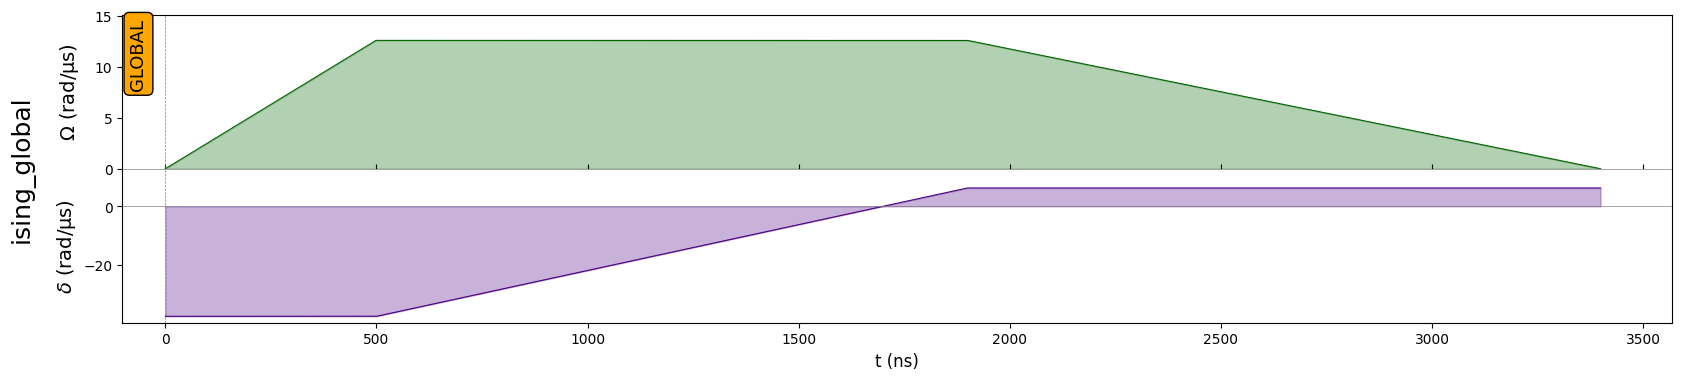

In [22]:
seq = afm_sequence_from_register(
    reg, Omega_max, delta_0, delta_f, t_rise, t_fall, sweep_factor, AnalogDevice
)
seq.draw("input")

### Using `emu-mps` as backend

As mentioned earlier, to run a simulation with emu-mps we need to provide two inputs: a pulse sequence — which we have just created — and a configuration object. 

The configuration for the `emu-mps` backend is created by instantiating the `MPSConfig` class. This class contains:

- the observables that we wish to measure, 
- the time step chosen for the simulation (`dt`),
- the solver algorithm to use (`solver`), which can be `Solver.TDVP` or `Solver.DMRG`,
- and various algorithm-specific parameters (explained in the documentation).

We start by setting a bigger discretization time than the default one provided ($dt=10$) and enforcing that the times at which we compute the observables are an integer multiple of $dt$. 

For simplicity, we will measure the observables only at the final time of the simulation.

We also fix the basis along which the measurements will be done. For the details regarding the conventions used we refer to the [Pulser documentation](https://pulser.readthedocs.io/en/stable/conventions.html).

In [23]:
dt = 100
eval_times = [1.0]

basis = ("r","g")

### Observables in `emu-mps`

 Among the default observables available in the `emu-mps` backend, we focus on three in this example:
- **BitString sampling**
- **Fidelity of the evolved state**
- **Occupation**

#### BitString samples
It samples at desired time steps the evolved state, returning the *bitStrings* in a counter

In [24]:
shots = 1000
bitstrings = BitStrings(evaluation_times=eval_times, num_shots=shots)

#### Fidelity

The *fidelity* is computed as $\langle \psi_{evolved} | \phi_{given} \rangle$ where 
- $\psi_{evolved}$ is the system state at desired steps
- $\phi_{given}$ is the state in which we want to project the state system.

In this tutorial we compute the fidelity against the dominant of the two antiferromagnetic states $\phi_{given} = |rgrgrgrg>$

In [25]:
nqubits = len(seq.register.qubit_ids)

afm_string_pure = {"rgrgrgrg": 1.0}

afm_mps_state = MPS.from_state_amplitudes(
    eigenstates=basis, amplitudes=afm_string_pure
)
fidelity_mps_pure = Fidelity(evaluation_times=eval_times, state=afm_mps_state)

#### Occupation
It is computed as $\langle \psi_{evolved} |\frac{(1+Z_i)}{2}|\psi_{evolved}\rangle$ and often informally referred to as the *magnetization* at each atom site.

In [26]:
density = Occupation(
    evaluation_times=[x/seq.get_duration() for x in range(0, seq.get_duration(), dt)]
)

##### Creating the MPS configuration object

After choosing the observables you wish to study, you are ready to create the MPS configuration object `MPSConfig`.

The `MPSConfig` class has the `solver` argument, which determines which algorithm will be used for the simulation:
- **Solver.DMRG**: runs the simulation using the DMRG algorithm.
- **Solver.TDVP**: runs the simulation using the TDVP algorithm (default). 

> Note 1: if no solver is specified, `TDVP` will be used by default.

> Note 2: the **DMRG** solver should be used **only for adiabatic pulse sequences**, where the system evolves slowly enough for DMRG to produce accurate results. It is not intended for general-purpose Pulser sequence simulations.


In [27]:
mpsconfig = MPSConfig(
    dt=dt,
    observables=[
        bitstrings,
        fidelity_mps_pure,
        density,
    ],
    solver=Solver.DMRG,
)

emu-mps allows only {'bitstrings', 'occupation', 'energy_variance', 'correlation_matrix', 'energy_second_moment', 'energy', 'statistics'} observables with `optimize_qubit_ordering = True`. you provided unsupported {'fidelity'} using `optimize_qubit_ordering = False` instead.


### Running the simulation

With all the ingredients in place, we can now run the simulation.

We instantiate the backend class `MPSBackend` and call its `run` method, where we pass as argument the sequence (`seq`) and the MPSConfig object `mpsconfig`.

In [28]:
sim = MPSBackend(seq, config=mpsconfig)
results = sim.run()

emu-mps allows only {'bitstrings', 'occupation', 'energy_variance', 'correlation_matrix', 'energy_second_moment', 'energy', 'statistics'} observables with `optimize_qubit_ordering = True`. you provided unsupported {'fidelity'} using `optimize_qubit_ordering = False` instead.


## Inspecting the result object

In the following code, we provide brief examples of how to extract information from the `results` object returned by the simulation.

In [29]:
results.get_result_tags()

['occupation', 'statistics', 'bitstrings', 'fidelity']

#### Bitstrings analysis

Below, we retrieve the bistrings computed in the simulation.

Since we measured observables only at the final time (`ns = 3400`), we expect results only for that time. 
We also find identify the bitstrings that were sampled most frequently and report their relative counts.

The most frequent bitstring is ['10101010'] which was sampled 990 times


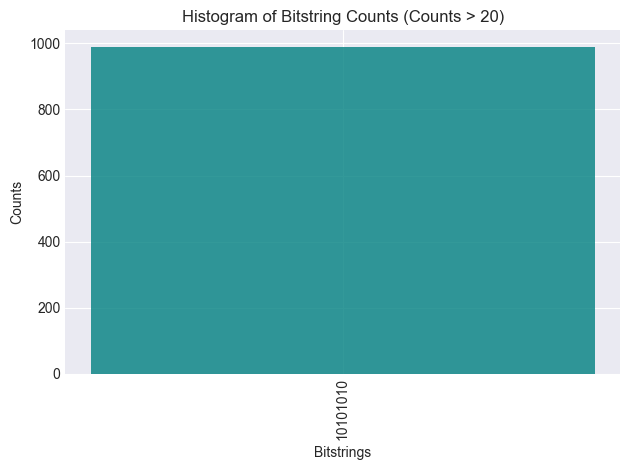

In [30]:
results.get_result_times(bitstrings)
bitstrings_final = results.get_result(bitstrings, 1.0)

max_val = max(bitstrings_final.values())  # max number of counts in the bitstring
max_string = [key for key, value in bitstrings_final.items() if value == max_val]
print(
    "The most frequent bitstring is {} which was sampled {} times".format(
        max_string, max_val
    )
)

filtered_counts = [count for count in bitstrings_final.values() if count > 20]
filtered_bitstrings = [
    bitstring for bitstring, count in bitstrings_final.items() if count > 20
]
x_labels = range(len(filtered_bitstrings))
with plt.style.context("seaborn-v0_8-darkgrid"):
    fig, ax = plt.subplots()
    ax.bar(x_labels, filtered_counts, color="teal", alpha=0.8)
    ax.set_xlabel("Bitstrings")
    ax.set_ylabel("Counts")
    ax.set_title("Histogram of Bitstring Counts (Counts > 20)")
    ax.set_xticks(x_labels)
    ax.set_xticklabels(filtered_bitstrings, rotation="vertical")
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    plt.tight_layout()
    plt.show()

> **Observation:**  
> The DMRG solver successfully found the AFM state at the end of the simulation.  
> The bitstring `['10101010']` was sampled 993 times out of 1000, indicating that the system reached the expected AFM state.


#### Fidelity analysis

Here we compute the fidelity of the system against the two different AFM state realizations defined above.  

In [31]:
fidelity_pure = results.get_result(fidelity_mps_pure,1.0)

print(
    "The fidelity computed for the system final state against the pure state |rgrgrgr> is {}.\nThe probability of the system being in that state is equal to {} ".format(
        fidelity_pure, abs(fidelity_pure) ** 2
    )
)

The fidelity computed for the system final state against the pure state |rgrgrgr> is 0.9912823542650832.
The probability of the system being in that state is equal to 0.9826407058773258 


### Evolution of the state in time

Here, we plot the time evolution of the magnetization of the system sites, and we observe how the system slowly reaches the AFM state.

In [32]:
magnetization_values = np.array(list(results.occupation))
magnetization_times = results.get_result_times(density)

In [33]:
# rescaling the time
real_times = []
for time in magnetization_times:
    real_times.append(time * seq.get_duration())

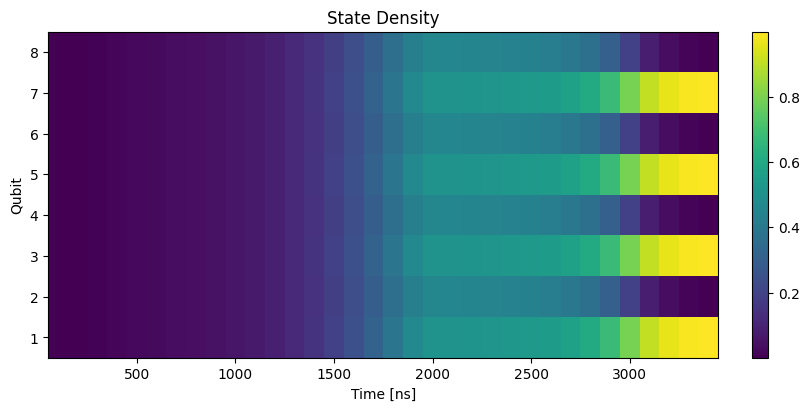

In [34]:
fig, ax = plt.subplots(figsize=(8, 4), layout="constrained")

num_time_points, positions = magnetization_values.shape
x, y = np.meshgrid(np.arange(num_time_points), np.arange(1, positions + 1))
im = plt.pcolormesh(real_times, y, magnetization_values.T, shading="auto")
ax.set_xlabel("Time [ns]")
ax.set_ylabel("Qubit")
ax.set_title("State Density")
ax.set_yticks(np.arange(1, positions + 1))
cb = fig.colorbar(im, ax=ax)